In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/My Drive/Mestrado/2021.1/Redes Neurais Artificiais/RNA/')

In [ ]:
import numpy as np
import pandas as pd
import math

from models import utils, metrics, plots

from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import random
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt

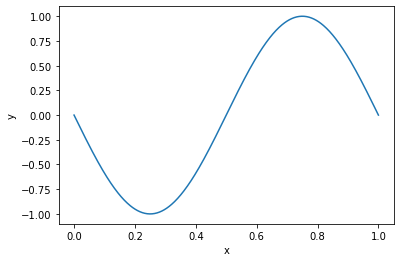

In [14]:
x = np.linspace(-np.pi, np.pi, 500)
y = np.sin(x)
df_artificial_1 =  pd.DataFrame(data=zip(x,y), columns =['x', 'target'])
for col in df_artificial_1.columns:
    if col != 'target':
        df_artificial_1 = utils.normalize_col(df_artificial_1, col)
plt.plot(df_artificial_1['x'], df_artificial_1['target'])
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

In [149]:
X_train, y_train, X_test, y_test = utils.split_train_test(df_artificial_1, 'target', train_size=0.8, stratify=None)

df_train = X_train.copy()
df_train['target'] = [[y] for y in y_train]

df_test = X_test.copy()
df_test['target'] = [[y] for y in y_test]

In [150]:
class RBF():

    def __init__(self, n_neuron_hide=5, sigma=2, qt_classes=3):

        self.q = n_neuron_hide
        self.sigma = sigma
        self.qt_classes = qt_classes

    def logistic(u):
        return 1.0 / (1.0 + np.exp(-u))

    def tanh(u):
        return (1 - np.exp(-u)) / (1 + np.exp(-u))
    
    def degrau(u, threshold=0):
        if u >= threshold: return 1
        else: return 0

    def get_optimal_weigths(df_train, col_target='target', qt_classes=3):
        '''
        Função da OLAM
        '''
        X = np.asmatrix(df_train.drop([col_target], axis=1).values)
        D = np.asmatrix(np.array(df_train[col_target].tolist()))
        W = np.linalg.pinv(X) * D

        return W

    def predict_row(row, W, qt_classes=3):
        '''
        Função da OLAM
        '''
        return np.dot(row, W)


    def predict_dataframe(df, W, qt_classes=3):
        '''
        Função da OLAM
        '''
        list_result = []
        for idx, _ in df.iterrows():
            list_result.append(RBF.predict_row(df.iloc[idx], W, qt_classes=qt_classes))

        return list_result
    
    
    def fit(self, X_train, y_train):

        df_train = X_train.copy()
        df_train['target'] = [[y] for y in y_train]

        self.padroes_centro = np.random.uniform(size=(self.q, len(X_train.columns))) #row, col
        list_h = []
        for idx, row in X_train.iterrows():

            x = X_train.iloc[idx].tolist()
            
            h = []
            for padrao in self.padroes_centro:
                sub = np.subtract(np.array(x), np.array(padrao))
                calc = np.exp(-(np.dot(np.array(sub).T, np.array(sub)) / 2 * (self.sigma ** 2)))
                h.append(calc)

            list_h.append(h)

        M = np.asmatrix(list_h)
        input_olam = np.insert(M, 0, -1, axis=1)
        df_input_olam = pd.DataFrame(input_olam, columns = [f'h{i}' for i in range(input_olam.shape[1])])
        df_input_olam['target'] = df_train['target']

        self.weigths = RBF.get_optimal_weigths(df_input_olam, col_target='target', qt_classes=self.qt_classes)

    
    def predict(self, X_test):

        list_h_test = []
        for idx, row in X_test.iterrows():

            x = X_test.iloc[idx].tolist()
            
            h = []
            for padrao in self.padroes_centro:
                
                sub = np.subtract(np.array(x), np.array(padrao))
                calc = np.exp(-(np.dot(np.array(sub).T, np.array(sub)) / 2 * (self.sigma ** 2)))
                h.append(calc)

            list_h_test.append(h)

        M_teste = np.asmatrix(list_h_test)
        input_olam_test = np.insert(M_teste, 0, -1, axis=1)
        df_input_olam_test = pd.DataFrame(input_olam_test, columns = [f'h{i}' for i in range(input_olam_test.shape[1])])
        
        X_test['predict'] = RBF.predict_dataframe(df_input_olam_test, self.weigths, self.qt_classes)
        X_test['predict'] = X_test['predict'].astype(str)
        X_test['predict'] = X_test['predict'].apply(lambda x: str(str(x).replace('[', '').replace(']', '')))
        X_test['predict'] = X_test['predict'].astype(float)

        return X_test['predict']


In [151]:
model_rbf = RBF(n_neuron_hide=5, sigma=0.1, qt_classes=1)

In [152]:
model_rbf.fit(df_train.drop(['target'], axis=1).copy(), df_train['target'])

In [153]:
df_test['predict'] = model_rbf.predict(X_test.copy())

In [154]:
df_test['target'] = df_test['target'].apply(lambda x: x[0])
df_test['predict'] = df_test['predict'].astype(str)
df_test['predict'] = df_test['predict'].apply(lambda x: str(str(x).replace('[', '').replace(']', '')))
df_test['predict'] = df_test['predict'].astype(float)

In [155]:
df_test['error'] = (df_test['target'] - df_test['predict']) ** 2

In [156]:
df_test.head(20)

,x,target,predict,error
0,0.124248,-0.703760,-0.798436,0.008963
1,0.166333,-0.864974,-0.942292,0.005978
2,0.390782,-0.633633,-0.559041,0.005564
3,0.362725,-0.759485,-0.681436,0.006092
4,0.675351,0.892005,0.818387,0.005420
5,0.494990,-0.031474,-0.025439,0.000036
6,0.779559,0.982803,0.995287,0.000156
7,0.721443,0.983946,0.938435,0.002071
8,0.909820,0.536783,0.611655,0.005606
9,0.543086,0.267424,0.231893,0.001262


In [157]:
MSE = df_test['error'].mean() #MSE
MSE

0.004910300952318917

In [158]:
RMSE = np.sqrt(MSE) 
RMSE

0.07007353960175636